In [11]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np # convert it into 2D 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data 

In [12]:
df = pd.read_csv("0700.HK.csv", usecols=['Date', 'Close'])
df.sort_values(by=['Date'], ascending=1)


,Date,Close
0,2018-05-28,405.200012
1,2018-05-29,402.000000
2,2018-05-30,395.000000
3,2018-05-31,399.200012
4,2018-06-01,404.000000
...,...,...
1227,2023-05-19,333.200012
1228,2023-05-22,340.200012
1229,2023-05-23,335.600006
1230,2023-05-24,332.399994


In [13]:
timeseries = df[["Close"]].values.astype('float32')  # set as array
timeseries

array([[405.2],
       [402. ],
       [395. ],
       ...,
       [335.6],
       [332.4],
       [322.4]], dtype=float32)

In [14]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [15]:
def create_dataset(dataset, lookback): 
    """ Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    
    # Here we are initializing two dimensions 
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i+lookback]   # first dimension
        target = dataset[i+1:i+lookback+1] # second dimension
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [16]:
lookback = 4 # Look back window = 4 days
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

C:\Users\Terrence Poon\AppData\Local\Temp\ipykernel_12336\1845662223.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\torch\csrc\utils\tensor_new.cpp:204.)
  return torch.tensor(X), torch.tensor(y)


In [17]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    


In [18]:
model = AirModel()
model

AirModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [31]:
optimizer = optim.Adam(model.parameters()) # Adam ~= Gradient Descent
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
optimizer
# loss_fn

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [20]:
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    

Epoch 0: train RMSE 449.4399, test RMSE 369.8002
Epoch 100: train RMSE 182.3082, test RMSE 100.5813
Epoch 200: train RMSE 60.4013, test RMSE 37.1632
Epoch 300: train RMSE 21.3445, test RMSE 16.5694
Epoch 400: train RMSE 14.5003, test RMSE 15.3305


In [21]:
with torch.no_grad():
    # Shift train predictions for plotting 
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # Shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size + lookback:len(timeseries)] = model(X_test)[:, -1, :]

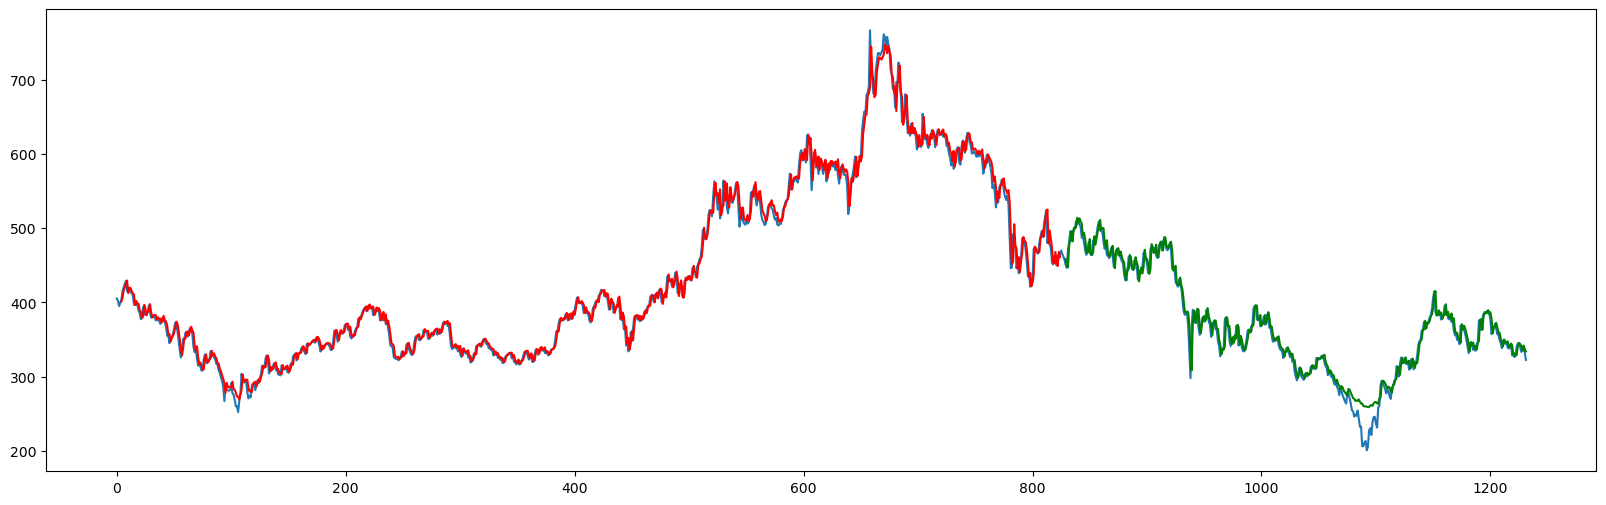

In [28]:
# Plot
plt.figure(figsize=(20,6))
plt.plot(timeseries)
plt.plot(train_plot, c = 'r')
plt.plot(test_plot, c = 'g')
plt.show()

In [ ]:
# how to interpret the results?
# what if there are multiple inputs and outputs